# Predicting Building Energy Use

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/NYC_Downtown_Manhattan_Skyline_seen_from_Paulus_Hook_2019-12-20_IMG_7347_FRD_%28cropped%29.jpg/1600px-NYC_Downtown_Manhattan_Skyline_seen_from_Paulus_Hook_2019-12-20_IMG_7347_FRD_%28cropped%29.jpg" alt="NYC Downtown Manhattan Skyline seen from Paulus Hook - Fred Hsu on en.wikipedia - Own work" class="center">

## Project Understanding and Technical Overview

This notebook covers the modeling performed with the [NYC Open Data](https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/usc3-8zwd) dataset to predict annual electricity usage for buildings. The model uses building size, primary use and energy efficiency information to make a prediction on the annual electricity use. Identifying the important features in determining electricity use could help to inform energy credit programs that can incentivize energy abusers.

The dataset has 256 columns to work with. Each observation is a building. There are several tracked annual energy readings for each building. The electricity purchased from the energy grid is chosen as the target due to it being reported on by the utility company instead of self-reporting (less prone to errors). Recursive Feature Elimination is used to select the most significant features for modeling. Missing values are imputed using the median. Categorical columns are encoded.

The first simple model uses linear regression which produces an RMSE of 940 MWh. The final ensemble model is a Random Forest Regressor which produces an RMSE of 614 MWh. The average annual electricity usage for a building >50,000 sqft in NYC is 975 MWh +/- 1,700 MWh.

## Business Understanding

Buildings account for 76% of all electricity use in the United States. This translates to 40% of total greenhouse gas emissions from baseline power (coal and oil). Over half of a buildings energy draw comes from environment control:

* lighting
* cooling
* heating
* ventilation
* refrigeration

<img src="images/piechart.png" class="center" width="400" height="400" >

New York State Energy Plan:

*"The State Energy Plan is a comprehensive roadmap to build a clean, resilient, and affordable energy system for all New Yorkers. The Plan coordinates every State agency and authority that touches energy to advance the REV agenda, unleashing groundbreaking regulatory reform to integrate clean energy into the core of our power grid, redesigning programs to unlock private capital, and actively deploying innovative energy solutions across the State’s own public facilities and operations."* ([EnergyPlan.NY.gov](https://energyplan.ny.gov/))

The plan has the following goals for the state:

* 40% reduction in greenhouse gas emissions from 1990 levels
* 50% of energy generation from renewable energy sources
* 600 trillion Btu increase in statewide energy efficiency

Being able to predict the annual electricity usage of a building based on it's size, primary use and energy efficiency rating would allow for better municipal planning and could help with identifying buildings that over-consume. This would be ideal for planning city sustainability projects as energy consumption could be predicted based on a forecasted change in energy efficiency of buildings. Based on required energy reductions predicted by this model the state could tailor sustainability programs to incentivize building managers to increase energy efficiency (reduce energy consumption).



## Data Understanding

**Target Variable - Annual Electricity Usage:**

Energy use is typically tracked in kWh (killowatt hours) or MWh (megawatt hours = 1,000 killowatt hours) using electric meters installed by a utility company. NYC's Local Law 87 requires that buildings over 50,000 sqft undergo energy audits which include accurate, annual reporting of energy usage. Over 20,000 buildings within New York City fall under this law.

<img src="images/smart_meter.jpg" class="center">

**Building Energy Efficiency:**

A building's EnergyStar Score is a relative benchmark to other buildings of similar qualities. The higher the score the more energy efficient that building is. An EnergyStar Score of 50 is the median energy efficiency. In the state of New York, buildings above an EnergyStar Score of 70 are eligible for rebates through special state run programs.

**Primary Use:**

The primary use of a building is a general building classification. The top 5 classifications:
1. Multifamily Housing
2. Office
3. K-12 School
4. College/University
5. Hotel

## Data Exploration

Below the necessary imports are loaded.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.api import qqplot

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

The data comes from [NYC Open Data](https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/usc3-8zwd). The target column is the 'Electricity Use - Grid Purchase (kWh)'. Here, the dataset is read in and the used columns are filtered for.

In [3]:
df = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2018__Data_for_Calendar_Year_2017_.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (14,31,32,111,113,127,206,236,237,238) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
dfx = df.filter(['Property Id','Primary Property Type - Self Selected','Largest Property Use Type - Gross Floor Area (ft²)','Year Built','ENERGY STAR Score','ENERGY STAR Certification - Eligibility','Electricity Use - Grid Purchase (kWh)']).copy(deep=True)

The building floor square footage histogram is skewed right with an average floor square footage of 120,000 sqft.

<AxesSubplot:ylabel='Frequency'>

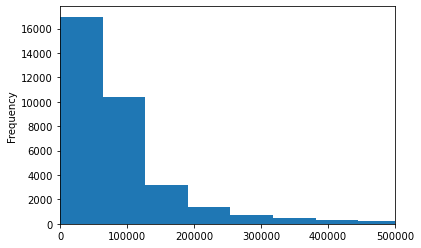

In [14]:
dfx['Largest Property Use Type - Gross Floor Area (ft²)'].plot(kind='hist', xlim=(0,500_000),bins=300)

In [16]:
dfx[['Largest Property Use Type - Gross Floor Area (ft²)']].describe()

,Largest Property Use Type - Gross Floor Area (ft²)
count,3.465400e+04
mean,1.196239e+05
std,2.950392e+05
min,1.000000e+00
25%,4.195400e+04
50%,6.489500e+04
75%,1.132290e+05
max,1.908114e+07


## Data Cleaning

Dropping Duplicate Buildings in dataset based on property id. Duplicates may exist due to self-reporting. A building could have reported twice or more.

In [20]:
dfx.drop_duplicates('Property Id',inplace=True)

In [21]:
dfx.drop('Property Id',axis=1,inplace=True)
print('Starting Buildings Count:',df.shape[0],'|','Starting Columns Count:',df.shape[1])
print('Buildings Count:',dfx.shape[0],'|','Feature Count:',dfx.shape[1]-1)

Starting Buildings Count: 34686 | Starting Columns Count: 256
Buildings Count: 22681 | Feature Count: 5


Label encoding the EnergyStar Certification Eligibility column. Reminder - buildings who meet the eligibility have an EnergyStar Score of 70 or greater (in the top 30% of energy performance relative to similar buildings).

In [22]:
def energystar(x):
    if x == 'No':
        return 0
    else:
        return 1

dfx['ENERGY STAR Certification - Eligibility'] = dfx['ENERGY STAR Certification - Eligibility'].map(energystar)

Renaming building primary uses to all be in English. Multiple languages for primary use are probably related to self-reporting where the reporter completed the survey in their first language.

In [23]:
def use_cleanup(x):
    if x == 'Collège/Université':
        return 'College/University'
    elif x == 'Immeuble à logements multiples':
        return 'Multifamily Housing'
    elif x == 'Bureau':
        return 'Office'
    elif x == 'Résidence/dortoir':
        return 'Residence Hall/Dormitory'
    elif x == 'Autre':
        return 'Other'
    elif x == 'Lieu de culte':
        return 'Worship Facility'
    elif x == 'Autre - Éducation':
        return 'Other - Education'
    elif x == 'Hôtel':
        return 'Hotel'
    elif x == 'Résidence pour personnes âgées':
        return 'Senior Care Community'
    elif x == 'Entreposage libre-service':
        return 'Self-Storage Facility'
    elif x == 'Entrepôt non réfrigéré':
        return 'Non-Refrigerated Warehouse'
    elif x == 'Supermarché/épicerie':
        return 'Supermarket/Grocery Store'
    elif x == 'Propriété à usage mixte':
        return 'Mixed Use Property'
    elif x == 'Commerce de détail':
        return 'Retail Store'
    elif x == 'Entrepôt réfrigéré':
        return 'Refrigerated Warehouse'
    elif x == 'Centre des arts de la scène':
        return 'Performing Arts'
    elif x == 'Patinoire/piste de curling':
        return 'Ice/Curling Rink'
    elif x == 'Autre - Divertissement/Rassemblement public':
        return 'Other - Entertainment/Public Assembly'
    elif x == 'Hôpital (soins médicaux et chirurgicaux)':
        return 'Hospital (General Medical & Surgical)'
    elif x == 'Usine de fabrication/industrie':
        return 'Manufacturing/Industrial Plant'
    else:
        return x

df['Primary Property Type - Self Selected'] = df['Primary Property Type - Self Selected'].map(use_cleanup)
dfx['Primary Property Type - Self Selected'] = dfx['Primary Property Type - Self Selected'].map(use_cleanup)

For this model we only want to look at buildings that have active electricity usage so any building with no usage is removed. Also, outliers more than 3.5 standard deviations from mean for electricity use are also removed.

In [24]:
before_drop_count = dfx.shape[0]
dfx = dfx[dfx['Electricity Use - Grid Purchase (kWh)'] > 0]
after_zero_drop = dfx.shape[0]
dfx = dfx[(np.abs(stats.zscore(dfx['Electricity Use - Grid Purchase (kWh)'])) < 3.5)]

In [25]:
print('Building Count Before Drop:',before_drop_count)
print('Building Count After Zero Drop:',after_zero_drop)
print('Building Count After Drop:',dfx.shape[0])
print('% Outlier Drop:',round((1-dfx.shape[0]/after_zero_drop)*100,1))

Building Count Before Drop: 22681
Building Count After Zero Drop: 20831
Building Count After Drop: 20610
% Outlier Drop: 1.1


Train/Test Split

In [26]:
X_train,X_test,y_train,y_test = train_test_split(dfx.drop(['Electricity Use - Grid Purchase (kWh)'],axis=1),dfx[['Electricity Use - Grid Purchase (kWh)']],random_state=42)

Imputing EnergyStar Scores. The mean is used as the filler which is ~50. A building with a score of 50 is a median performing building compared to it's peers (Neither energy efficient or poor performing).

In [27]:
X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

df_train = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([X_test,y_test],axis=1)

si = SimpleImputer()

df_train['ENERGY STAR Score'] = si.fit_transform(df_train[['ENERGY STAR Score']])
df_train['ENERGY STAR Score'] = si.transform(df_train[['ENERGY STAR Score']])

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

X_train = df_train.drop('Electricity Use - Grid Purchase (kWh)',axis=1)
X_test = df_test.drop('Electricity Use - Grid Purchase (kWh)',axis=1)
y_train = df_train['Electricity Use - Grid Purchase (kWh)']
y_test = df_test['Electricity Use - Grid Purchase (kWh)']

One Hot Encoding the Primary Use Input Variable. There are more than 60 unique primary uses.

In [28]:
ohe = OneHotEncoder(handle_unknown='ignore')

ohe_train_array = ohe.fit_transform(X_train[['Primary Property Type - Self Selected']])
ohe_train_df = pd.DataFrame(ohe_train_array.todense(),columns=[name[3:] for name in ohe.get_feature_names()])

ohe_test_array = ohe.transform(X_test[['Primary Property Type - Self Selected']])
ohe_test_df = pd.DataFrame(ohe_test_array.todense(),columns=[name[3:] for name in ohe.get_feature_names()])

X_train.reset_index(inplace=True,drop=True)
X_train_ohe = pd.concat([X_train,ohe_train_df],axis=1)
X_train_ohe.drop(['Primary Property Type - Self Selected'],axis=1,inplace=True)

X_test.reset_index(inplace=True,drop=True)
X_test_ohe = pd.concat([X_test,ohe_test_df],axis=1)
X_test_ohe.drop(['Primary Property Type - Self Selected'],axis=1,inplace=True)

In [29]:
print('Number of Features Pre OHE:',X_train.shape[1])
print('Number of Features Post OHE:',X_train_ohe.shape[1])

Number of Features Pre OHE: 5
Number of Features Post OHE: 68


## Modeling

### Simple Model

For the initial model linear regression is chosen as determining feature importance is a significant part of this evaluation and to make recommendations. For performance metrics, both Rsquared score (how much of the variability in annual electricity usage is explained) and RMSE are looked at with RMSE being the primary metric (how well can annual electricity usage be predicted).

In [30]:
lr = LinearRegression()
lr.fit(X_train_ohe,y_train)
print('Linear Regression Test R²:',lr.score(X_test_ohe,y_test))

Linear Regression Test R²: 0.6682202068525991


In [31]:
print('Linear Regression Test RMSE:',np.sqrt(mean_squared_error(y_test,lr.predict(X_test_ohe))))

Linear Regression Test RMSE: 940211.2359823538


### Simple Model Evaluation

#### Checking Normal Distribution of Input Variables

array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>], dtype=object)

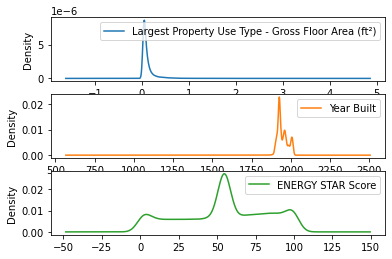

In [32]:
X_train_ohe.filter(['Largest Property Use Type - Gross Floor Area (ft²)','Year Built','ENERGY STAR Score'],axis=1).plot.kde(subplots=True,sharex=False)

#### Checking Normal Distribution of Residuals

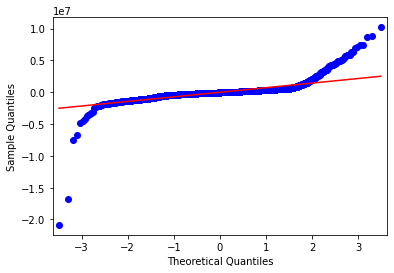

In [33]:
qqplot(y_test-lr.predict(X_test_ohe),line='r')
plt.show()

#### Checking for Heteroskedasticity of Residuals

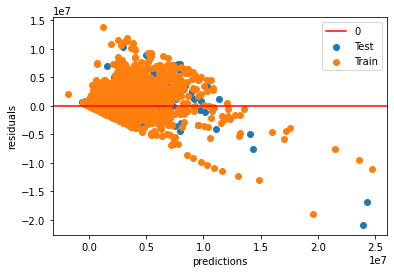

In [34]:
plt.scatter(lr.predict(X_test_ohe), y_test-lr.predict(X_test_ohe), label='Test')
plt.scatter(lr.predict(X_train_ohe), y_train-lr.predict(X_train_ohe), label='Train')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

#### Checking Multicollinearity of Input Variables

<AxesSubplot:>

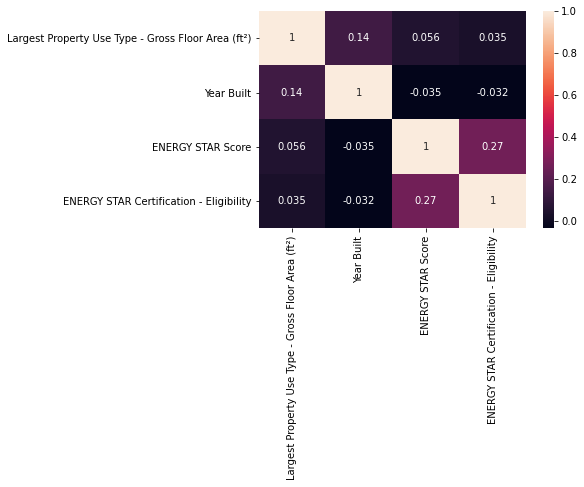

In [35]:
sns.heatmap(X_train.corr(),annot=True)

Residuals show a visible pattern for heteroskedasticity test. Q-Q plot shows residuals are also not normally distributed. Based on the above assumption checks, linear regression does not appear to be the best choice.

### Final Model

The next model chosen is a Decision Tree Regressor as the data fails to pass linear regression assumptions. This model performs worse than the linear regression model based on RMSE most likely due to overfitting. For the final model a Random Forest Regressor is chosen.

In [36]:
rfr = RandomForestRegressor()

#### Recursive Feature Elimination to reduce feature count

Originally this is run iteratively to identify where the returns on model performance plateau (<0.01 metric increase) out when features are added. 30 features ends up being an ideal choice.

In [37]:
rfe = RFE(rfr,n_features_to_select=30)
rfe.fit(X_train_ohe,y_train)

RFE(estimator=RandomForestRegressor(), n_features_to_select=30)

In [38]:
# final_list = ['Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built', 'ENERGY STAR Score', 'ENERGY STAR Certification - Eligibility', 'College/University', 'Data Center', 'Distribution Center', 'Financial Office', 'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School', 'Laboratory', 'Manufacturing/Industrial Plant', 'Medical Office', 'Mixed Use Property', 'Multifamily Housing', 'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Entertainment/Public Assembly', 'Other - Specialty Hospital', 'Parking', 'Prison/Incarceration', 'Residence Hall/Dormitory', 'Retail Store', 'Self-Storage Facility', 'Strip Mall', 'Supermarket/Grocery Store', 'Urgent Care/Clinic/Other Outpatient', 'Wastewater Treatment Plant']

In [39]:
keep_list = [(k,v) for k,v in zip(X_train_ohe.columns,rfe.support_)]
keep_string = ''
for k,v in keep_list:
    if v:
        keep_string += k + '+'
keep_string = keep_string[:-1]
final_list = [ x[0] for x in keep_list if x[1] ]

In [40]:
rfr.fit(X_train_ohe.filter(final_list),y_train)

RandomForestRegressor()

#### GridSearch to identify best performing parameters

In [41]:
params = {'n_estimators':np.linspace(10,400,num=10,dtype=int),
          'max_depth': np.linspace(1,100,num=5,dtype=int),
          'min_samples_split': np.linspace(2,50,num=5,dtype=int)}
gs = GridSearchCV(rfr,params)
gs.fit(X_train_ohe,y_train)
gs.best_params_

{'max_depth': 100, 'min_samples_split': 14, 'n_estimators': 270}

In [51]:
best_params = {'max_depth': 100, 'min_samples_split': 14, 'n_estimators': 270}

In [52]:
rfr = RandomForestRegressor(max_depth=best_params['max_depth'],min_samples_split=best_params['min_samples_split'],n_estimators=best_params['n_estimators'])
rfr.fit(X_train_ohe.filter(final_list),y_train)

RandomForestRegressor(max_depth=100, min_samples_split=14, n_estimators=270)

Cross Validation to check for overfitting.

In [53]:
cross_val_score(rfr,X_train_ohe.filter(final_list),y_train)

array([0.78967735, 0.80284851, 0.75922332, 0.8026217 , 0.77792711])

Performance On Test Data

In [54]:
rfr.score(X_test_ohe.filter(final_list),y_test)

0.8595734446929456

In [55]:
y_hat_train = rfr.predict(X_train_ohe.filter(final_list))
print('RMSE Train Data:',round(np.sqrt(mean_squared_error(y_train,y_hat_train))))
y_hat_test = rfr.predict(X_test_ohe.filter(final_list))
print('RMSE Test Data:',round(np.sqrt(mean_squared_error(y_test,y_hat_test))))

RMSE Train Data: 528887.0
RMSE Test Data: 611681.0


In [56]:
dfx[['Electricity Use - Grid Purchase (kWh)']].describe()

,Electricity Use - Grid Purchase (kWh)
count,2.061000e+04
mean,9.752697e+05
std,1.704314e+06
min,1.200000e+01
25%,2.164623e+05
50%,3.993497e+05
75%,9.134812e+05
max,1.536148e+07


## Findings

#### Feature Importance

Floor square footage was by far the most important feature based on impurity change per tree node followed by energy efficiency and primary uses.

In [66]:
features = [(x,y) for x,y in zip(rfr.feature_importances_,final_list)]
features.sort(key=lambda x: x[0],reverse=True)
df_feat = pd.DataFrame(features, columns = ['Importance by Impurity Change','Feature'])
df_feat.head(20)

,Importance by Impurity Change,Feature
0,0.693246,Largest Property Use Type - Gross Floor Area (...
1,0.097696,ENERGY STAR Score
2,0.063299,Multifamily Housing
3,0.049525,Year Built
4,0.037739,Office
5,0.010108,K-12 School
6,0.004839,Hospital (General Medical & Surgical)
7,0.004258,Mixed Use Property
8,0.004217,Parking
9,0.003117,Supermarket/Grocery Store


The final model is able to predict a building's annual electricity usage from the grid to within 612,000 kW h. The standard deviation of the dataset is 1,700,000 kW h.

#### Visualizing Top Energy Users

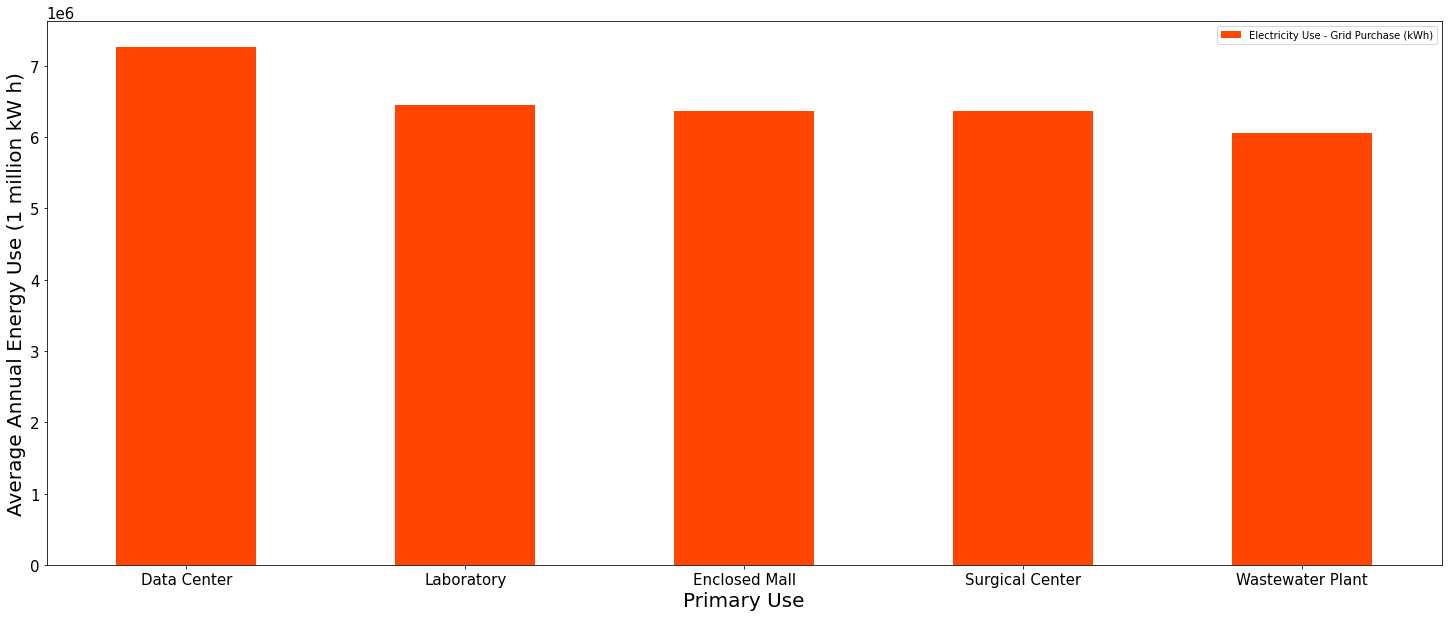

In [64]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20

def change_ent(x):
    if x == 'Hospital (General Medical & Surgical)':
        return 'Hospital'
    elif x == 'Refrigerated Warehouse':
        return 'Ref Warehouse'
    elif x == 'Non-Refrigerated Warehouse':
        return 'Non-Ref Warehouse'
    elif x == 'Wastewater Treatment Plant':
        return 'Wastewater Plant'
    elif x == 'Ambulatory Surgical Center':
        return 'Surgical Center'
    else:
        return x

dfx['Primary Property Type - Self Selected'] = dfx['Primary Property Type - Self Selected'].map(change_ent)

dfx.groupby('Primary Property Type - Self Selected').mean()[['Electricity Use - Grid Purchase (kWh)']].sort_values('Electricity Use - Grid Purchase (kWh)',ascending=False)[:5].plot(kind='bar',rot=0,xlabel='Primary Use',ylabel='Average Annual Energy Use (1 million kW h)',figsize=(25,10),color=['orangered','orange'])
plt.show()

The top energy users fall into categories that typically have large square footage buildings and contain energy intensive processes.

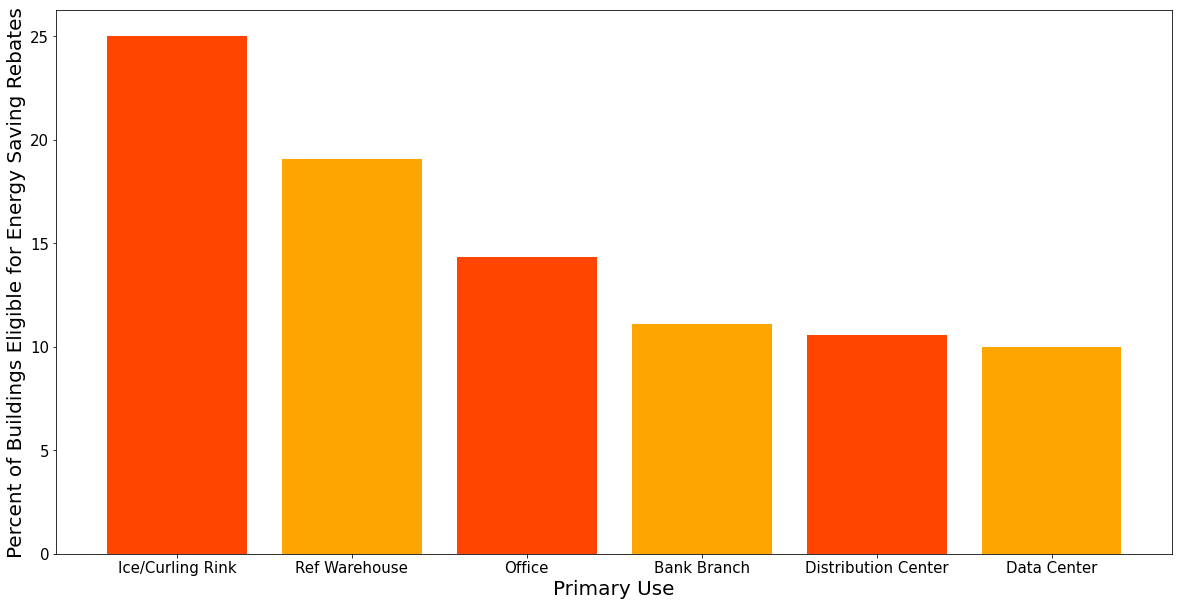

In [65]:
efficiency_list = []
# for x in dfx.value_counts('Primary Property Type - Self Selected').index:
#     temp_df = pd.DataFrame()
#     temp_df = dfx[dfx['Primary Property Type - Self Selected'] == x]
#     efficiency_list.append((x,temp_df['ENERGY STAR Certification - Eligibility'].sum()/temp_df.shape[0]*100))

df['Primary Property Type - Self Selected'] = df['Primary Property Type - Self Selected'].map(change_ent)

for x in df.value_counts('Primary Property Type - Self Selected').index:
    temp_df = pd.DataFrame()
    temp_df = df[df['Primary Property Type - Self Selected'] == x].drop_duplicates('Property Id')
    temp_df['ENERGY STAR Certification - Eligibility'] = temp_df['ENERGY STAR Certification - Eligibility'].map(energystar)
    efficiency_list.append((x,temp_df['ENERGY STAR Certification - Eligibility'].sum()/temp_df.shape[0]*100))

efficiency_list.sort(key=lambda x: x[1],reverse=True)

final_effic_list = efficiency_list[:6]

# final_effic_list = [('Office', 14.878892733564014), ('Bank Branch', 14.285714285714285), ('Refrigerated Warehouse', 12.5), ('Distribution Center', 10.989010989010989), ('Non-Refrigerated Warehouse', 8.02919708029197), ('Multifamily Housing', 6.050864409201314), ('Hospital (General Medical & Surgical)', 5.405405405405405)]

fig,ax = plt.subplots(figsize=(20,10))

ax.bar(x=[x[0] for x in final_effic_list],height=[y[1] for y in final_effic_list],color=['orangered','orange'])
ax.set(xlabel="Primary Use")
ax.set(ylabel="Percent of Buildings Eligible for Energy Saving Rebates")
plt.xticks(rotation=0)
plt.show()

The above graph shows the top performing primary uses by percentage of buildings that qualify for Energy Credits (70th percentile for energy efficiency). Ambulatory Surgical Centers and Wastewater Treatment Plants, while being in the top for energy consumption are not present in the top performing primary uses.

## Recommendations

- Focus energy efficiency incentive programs on high electricity use buildings that have the lowest percentage of energy credit qualifying buildings (Prisons, Surgical Centers, Wastewater Treatment Plants).
- Forecast Citywide Annual Electricity Usage by making predictions using a targeted energy efficiency metric. For example predict electricity usage for buildings using a goal energy efficiency metric (i.e. 5% increase in energy efficiency) to determine potential efficiency savings.

## Future Research

- Use sub-metering data in the model to include the exact energy use (HVAC,Lighting,Computers). For example, understanding which energy use by primary use of the building could help with creating more targeted incentive programs and recommended solutions.
<br> <br />
- Include building metadata on onsite electricity generation and engineered features such as:

    * Has Solar? Yes/No
    * Has COGEN? Yes/No
<br> <br />
- Incorporate weather data to show effects of seasonality on energy use